In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_feather("./../data/raw_text_DF.feather")
data["category"] = pd.Categorical(data["category"])
print(data.shape)
X = data["text"]
Y = pd.get_dummies(data["category"])
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.1)

(2225, 3)


In [4]:
import gensim
#load pretrain word2vec model 
model_w2v = gensim.models.Word2Vec.load('./../pretrain_models/simple_word2vec.model')  

# get word embedding matrix
embedding_layer = model_w2v.wv.get_keras_embedding(train_embeddings=False)


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# get pairs word:index(word) 
vocabulary = {token: token_index for token_index, token in enumerate(model_w2v.wv.index2word)} 
# change words to integer seq using indexes
tk = Tokenizer(num_words=len(vocabulary)) 
tk.word_index = vocabulary 

train_text_seq = tk.texts_to_sequences(train_X)
maxlen = max([len(text) for text in train_text_seq])
train_text_seq = pad_sequences(train_text_seq, maxlen=maxlen, padding="post", value=0.0)

test_text_seq = tk.texts_to_sequences(test_X)
test_text_seq = pad_sequences(test_text_seq, maxlen=maxlen, padding="post", value=0.0)



In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Dense, Embedding, Bidirectional, Dropout, LSTM
# define the model
model_NN = tf.keras.models.Sequential()

#model_NN.add(Embedding(len(vocabulary)+1,100,trainable=True))
model_NN.add(embedding_layer)

model_NN.add(Bidirectional(LSTM(16, return_sequences=False)))

model_NN.add(Dense(5, activation='softmax'))
# compile the model
model_NN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_NN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         4226700   
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                14976     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 4,241,841
Trainable params: 15,141
Non-trainable params: 4,226,700
_________________________________________________________________
None


In [7]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)
hist=model_NN.fit(train_text_seq,
                  train_Y,
                  epochs=1000,
                  batch_size=64, 
                  callbacks= es,
                  validation_data=(test_text_seq, test_Y),
                  verbose=1)

Epoch 1/1000
32/32 [==============================] - 30s 952ms/step - loss: 1.5281 - accuracy: 0.3526 - val_loss: 1.4075 - val_accuracy: 0.4619
Epoch 2/1000
32/32 [==============================] - 30s 934ms/step - loss: 1.2615 - accuracy: 0.5864 - val_loss: 1.0938 - val_accuracy: 0.6726
Epoch 3/1000
32/32 [==============================] - 29s 921ms/step - loss: 0.9820 - accuracy: 0.6968 - val_loss: 0.9859 - val_accuracy: 0.6592
Epoch 4/1000
32/32 [==============================] - 30s 923ms/step - loss: 0.8364 - accuracy: 0.7353 - val_loss: 0.8174 - val_accuracy: 0.7758
Epoch 5/1000
32/32 [==============================] - 29s 921ms/step - loss: 0.6848 - accuracy: 0.7992 - val_loss: 0.7605 - val_accuracy: 0.7758
Epoch 6/1000
32/32 [==============================] - 29s 916ms/step - loss: 0.6223 - accuracy: 0.8232 - val_loss: 0.7153 - val_accuracy: 0.7713
Epoch 7/1000
32/32 [==============================] - 30s 922ms/step - loss: 0.5695 - accuracy: 0.8307 - val_loss: 0.7133 - val_ac

Epoch 58/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0981 - accuracy: 0.9740 - val_loss: 0.3815 - val_accuracy: 0.9013
Epoch 59/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0941 - accuracy: 0.9770 - val_loss: 0.4147 - val_accuracy: 0.8834
Epoch 60/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0980 - accuracy: 0.9745 - val_loss: 0.4044 - val_accuracy: 0.8924
Epoch 61/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0899 - accuracy: 0.9750 - val_loss: 0.4190 - val_accuracy: 0.8789
Epoch 62/1000
32/32 [==============================] - 33s 1s/step - loss: 0.1032 - accuracy: 0.9720 - val_loss: 0.3934 - val_accuracy: 0.8924
Epoch 63/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0853 - accuracy: 0.9785 - val_loss: 0.3966 - val_accuracy: 0.8834
Epoch 64/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0812 - accuracy: 0.9790 - val_loss: 0.3857 - val_accuracy: 0.8879

32/32 [==============================] - 33s 1s/step - loss: 0.0993 - accuracy: 0.9755 - val_loss: 0.4398 - val_accuracy: 0.8924
Epoch 116/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0739 - accuracy: 0.9775 - val_loss: 0.3909 - val_accuracy: 0.9058
Epoch 117/1000
32/32 [==============================] - 33s 1s/step - loss: 0.0601 - accuracy: 0.9840 - val_loss: 0.3886 - val_accuracy: 0.9058


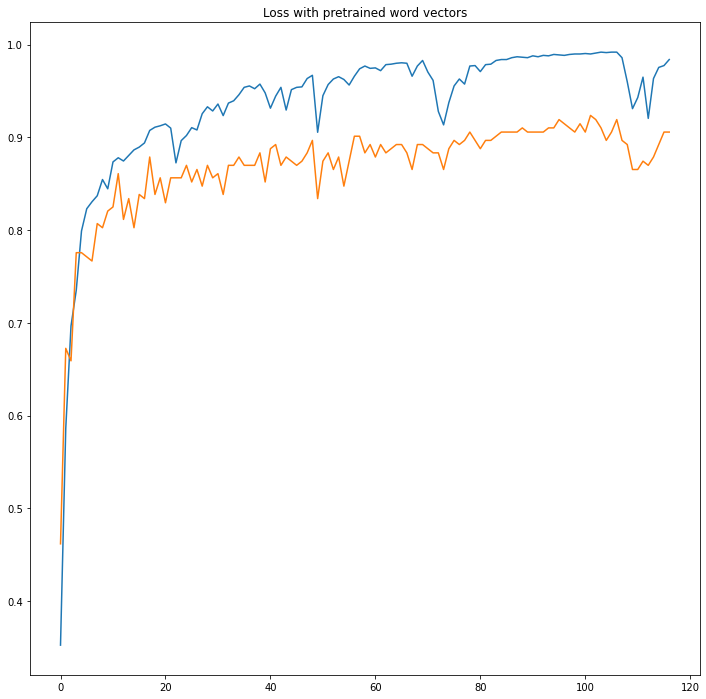

In [8]:
import matplotlib.pyplot as plt
print(hist)
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["accuracy"]);
plt.plot(history["val_accuracy"]);
plt.title("Loss with pretrained word vectors");
plt.show();